In [1]:
!pip install langchain_community
!pip install replicate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.1 MB/s eta 0:00:00


## Import Library & Setup API Key

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import userdata
from langchain_community.llms import Replicate

# Set up the API token from Colab Secrets
try:
    api_token = userdata.get('api_token')
    os.environ['REPLICATE_API_TOKEN'] = api_token
    print("API Token berhasil dimuat.")
except Exception as e:
    print(f"Error: API Token tidak ditemukan. Harap simpan di Colab Secrets.")
    api_token = None

API Token berhasil dimuat.


## Inisialisasi Model IBM Granite

In [3]:
# Model setup
if api_token:
    llm = Replicate(
        model="ibm-granite/granite-3.3-8b-instruct",
        model_kwargs={"temperature": 0.7, "max_new_tokens": 512}
    )
    print("Model IBM Granite berhasil diinisialisasi.")

Model IBM Granite berhasil diinisialisasi.


## Memuat Data

In [6]:
# Load the dataset
df = pd.read_csv('Test.csv')

# Display the first 5 rows
print("Contoh 5 baris pertama data:")
df.head()

Contoh 5 baris pertama data:


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6,B
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6,A
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6,A
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6,B
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6,A


## Eksplorasi & Pembersihan Data

In [7]:
# Get basic info and check for missing values
print("Informasi awal dataset:")
df.info()

# Handle missing values
df_cleaned = df.drop('ID', axis=1) # Drop irrelevant ID column

# Fill numerical missing values with the median
for col in ['Work_Experience', 'Family_Size']:
    if df_cleaned[col].isnull().sum() > 0:
        median_val = df_cleaned[col].median()
        df_cleaned[col].fillna(median_val, inplace=True)

# Fill categorical missing values with the mode
for col in ['Ever_Married', 'Graduated', 'Profession', 'Var_1']:
    if df_cleaned[col].isnull().sum() > 0:
        mode_val = df_cleaned[col].mode()[0]
        df_cleaned[col].fillna(mode_val, inplace=True)

print("\nInformasi dataset setelah pembersihan:")
df_cleaned.info()

Informasi awal dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               2627 non-null   int64  
 1   Gender           2627 non-null   object 
 2   Ever_Married     2577 non-null   object 
 3   Age              2627 non-null   int64  
 4   Graduated        2603 non-null   object 
 5   Profession       2589 non-null   object 
 6   Work_Experience  2358 non-null   float64
 7   Spending_Score   2627 non-null   object 
 8   Family_Size      2514 non-null   float64
 9   Var_1            2595 non-null   object 
 10  Segmentation     2627 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 225.9+ KB

Informasi dataset setelah pembersihan:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------   

/tmp/ipython-input-1116462328.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[col].fillna(median_val, inplace=True)
/tmp/ipython-input-1116462328.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

## Visualisasi Data

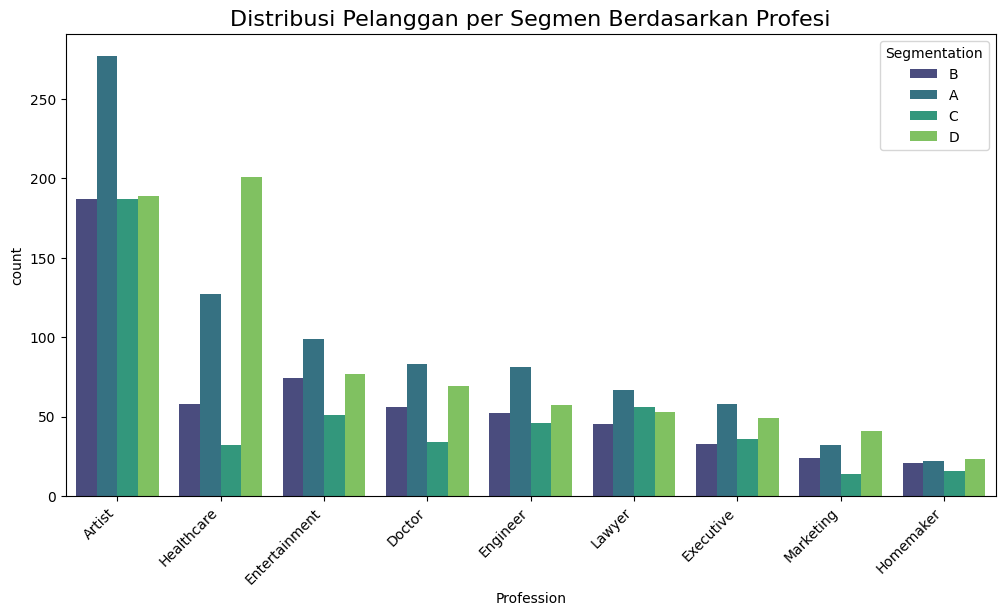

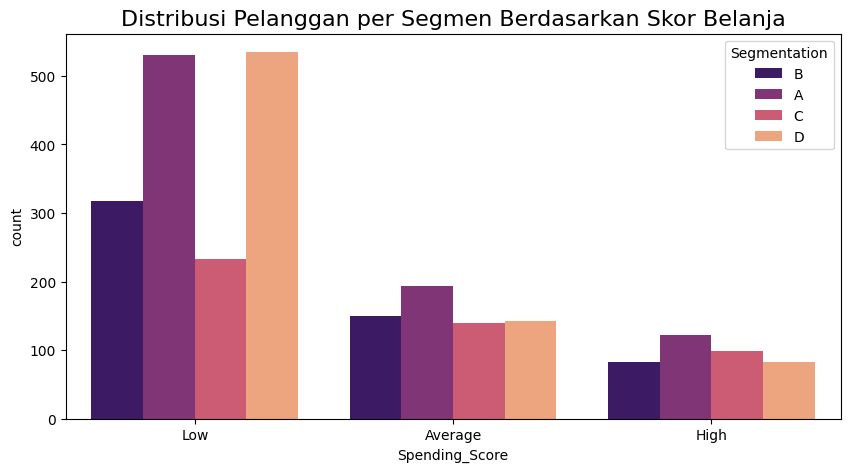

In [8]:
# Plot distribution for 'Profession'
plt.figure(figsize=(12, 6))
sns.countplot(data=df_cleaned, x='Profession', hue='Segmentation', palette='viridis', order=df_cleaned['Profession'].value_counts().index)
plt.title('Distribusi Pelanggan per Segmen Berdasarkan Profesi', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.show()

# Plot distribution for 'Spending_Score'
plt.figure(figsize=(10, 5))
sns.countplot(data=df_cleaned, x='Spending_Score', hue='Segmentation', palette='magma')
plt.title('Distribusi Pelanggan per Segmen Berdasarkan Skor Belanja', fontsize=16)
plt.show()

## Analisis AI: Summarization (Ringkasan)

In [9]:
def summarize_segment(segment_name, df):
    """
    Menghasilkan ringkasan naratif yang kaya dan akurat untuk segmen pelanggan
    menggunakan data statistik yang lebih detail.
    """
    if not api_token:
        return "API Token tidak tersedia."

    # Filter data untuk segmen spesifik
    segment_data = df[df['Segmentation'] == segment_name]

    # --- Mengumpulkan Data Statistik yang Lebih Kaya ---

    # 1. Statistik Usia: Tambahkan rata-rata
    age_min = segment_data['Age'].min()
    age_max = segment_data['Age'].max()
    age_mean = segment_data['Age'].mean()
    age_stats = f"Rentang: {int(age_min)}-{int(age_max)} tahun, dengan Rata-rata Usia: {int(age_mean)} tahun"

    # 2. Statistik Profesi: Ambil 3 teratas untuk insight yang lebih dalam
    top_professions = segment_data['Profession'].value_counts().nlargest(3)
    profession_stats = ', '.join([f"{prof} ({count} orang)" for prof, count in top_professions.items()])

    # 3. Distribusi Skor Belanja: Ambil semua kategori untuk gambaran lengkap
    spending_distribution = segment_data['Spending_Score'].value_counts()
    spending_stats = ', '.join([f"{score} ({count} orang)" for score, count in spending_distribution.items()])

    # 4. Status Pernikahan: Gunakan persentase
    married_dist = segment_data['Ever_Married'].value_counts(normalize=True)
    married_stats = ', '.join([f"{status} ({pct:.0%})" for status, pct in married_dist.items()])

    prompt = f"""
    Anda adalah seorang analis data ahli yang bertugas membuat profil pelanggan untuk tim pemasaran.
    Analisis data ringkas di bawah ini dan buat ringkasan naratif dalam SATU PARAGRAF singkat dan padat.

    Tugas Utama:
    - Jelaskan profil khas pelanggan di segmen ini.
    - Fokus pada karakteristik yang paling membedakan mereka.
    - Gunakan Bahasa Indonesia yang natural dan profesional.

    Aturan Output:
    - HANYA dalam Bahasa Indonesia.
    - JANGAN gunakan daftar (list) atau poin-poin (bullet points).
    - JANGAN sertakan terjemahan bahasa Inggris.
    - Buat dalam satu paragraf saja.

    --- Data Summary for Segment {segment_name} ---
    - Rata-rata Usia: {age_stats}
    - 3 Profesi Teratas: {profession_stats}
    - Distribusi Skor Belanja: {spending_stats}
    - Status Pernikahan: {married_stats}
    --- End of Data ---

    Ringkasan Profil Pelanggan (Satu Paragraf):
    """

    print(f"\nMembuat ringkasan (improved) untuk Segmen {segment_name}...")
    response = llm.invoke(prompt)
    return response

segments = ['A', 'B', 'C', 'D']
for seg in segments:
    summary = summarize_segment(seg, df_cleaned)
    print(f"--- Ringkasan AI untuk Segmen {seg} ---")
    print(summary)
    print("-" * 50)


Membuat ringkasan (improved) untuk Segmen A...
--- Ringkasan AI untuk Segmen A ---
Segmen A dipercaya memiliki profil pelanggan yang cukup variabel, terukir dari rentang usia yang luas, 18 hingga 89 tahun, dengan rata-rata usia 43 tahun. Profesionalitas mereka tergantung pada berbagai bidang, dengan tiga profesi teratas yaitu artistik (277 orang), kesehatan (127 orang), dan entertainment (99 orang). Distribusi skor belanja mereka juga cukup bervariasi, dengan jumlah besar yang terklasifikasikan sebagai konsumen rata-rata (194 orang), mengikuti kedua konsumen rendah (530 orang) dan rendah ke atas (122 orang). Aspek sosial, dilihat dari status pernikahan, menunjukkan kesetaraan antara mereka yang pernikahan (59%) dan tidak pernikahan (41%). Segmen ini secara keseluruhan dikenal memiliki pelanggan yang banyak bervariasi dalam aspek usia, profesi, tingkat kebutuhan, dan status pernikahan.
--------------------------------------------------

Membuat ringkasan (improved) untuk Segmen B...
--

## Analisis AI: Classification (Klasifikasi)

In [10]:
def classify_customer(customer_data):
    """
    Mengklasifikasikan pelanggan baru dengan instruksi dan format contoh yang lebih jelas.
    """
    if not api_token: return "API Token tidak tersedia."

    prompt = f"""
    Anda adalah sistem klasifikasi otomatis.
    Tugas Anda adalah mengklasifikasikan pelanggan baru ke dalam satu segmen: A, B, C, atau D.
    Gunakan contoh-contoh di bawah sebagai panduan utama Anda.

    Aturan Output:
    - Berikan HANYA SATU HURUF segmen (A, B, C, atau D) sebagai jawaban.
    - Jangan memberikan penjelasan atau kalimat tambahan.

    --- Contoh Klasifikasi ---
    - Profil: Gender: Male, Usia: 37, Profesi: Healthcare, Skor Belanja: Average, Ukuran Keluarga: 4
    - Hasil: A

    - Profil: Gender: Female, Usia: 36, Profesi: Engineer, Skor Belanja: Low, Ukuran Keluarga: 1
    - Hasil: B

    - Profil: Gender: Male, Usia: 59, Profesi: Executive, Skor Belanja: High, Ukuran Keluarga: 2
    - Hasil: C

    - Profil: Gender: Male, Usia: 61, Profesi: Doctor, Skor Belanja: Low, Ukuran Keluarga: 3
    - Hasil: D
    --- Akhir Contoh ---

    Sekarang, klasifikasikan profil pelanggan baru berikut:

    - Profil Baru: Gender: {customer_data['Gender']}, Usia: {customer_data['Age']}, Profesi: {customer_data['Profession']}, Skor Belanja: {customer_data['Spending_Score']}, Ukuran Keluarga: {int(customer_data['Family_Size'])}
    - Hasil:
    """

    print(f"\nMengklasifikasikan pelanggan baru (improved)...")
    response = llm.invoke(prompt)
    # Membersihkan output untuk memastikan hanya satu huruf yang diambil
    return response.strip().split()[0]

new_customer = {
    'Gender': 'Female',
    'Age': 25,
    'Profession': 'Artist',
    'Spending_Score': 'Low',
    'Family_Size': 2
}

predicted_segment = classify_customer(new_customer)
print(f"\nProfil Pelanggan Baru: {new_customer}")
print(f"Hasil Klasifikasi AI (Improved): Segmen {predicted_segment}")


Mengklasifikasikan pelanggan baru (improved)...

Profil Pelanggan Baru: {'Gender': 'Female', 'Age': 25, 'Profession': 'Artist', 'Spending_Score': 'Low', 'Family_Size': 2}
Hasil Klasifikasi AI (Improved): Segmen B
